# 3D Fits Guide

### Feb 1 2018

This is by no means complete, but might be useful to make the 3D fitting program I've made somewhat usable for others.  To start, I'd recommend trying to get ```analysis/getBox.py``` to work with a known strong peak.  This script is a sandbox of sorts for testing out TOF fitting ($\sim 1/q_r$) and loads variables that make it straightforward to play with BVG fitting in ($q_{\phi}, q_{\theta}$).  At the top of the file, you'll see a bunch of different samples I've been testing with.  Comment out the current one and make your own.  Here's what each input is:

- ```loadDir``` - the directory containing nevent nexus files you'll be reading.
- ```peaksFile``` - an ISAW style peaks file (\*.integrate) that you'll be reading to get peaks.
- ```UBFile``` - an ISAW style UB Matrix that'll be used for determining how big of a volume in reciprocal space to sample.
- ```DetCalFile``` - mantid DetCal file for instrument.  If one is not needed, leave as ```None```
- ```workDir``` - the directory that contains all of the run analysis (so I'll save things in dropbox/descriptor, for instance
- ```nxsTemplate``` - a template for each of the nxsFiles you'll be reading.  Set to accept an integer as the runNumber for the peak.
- ```panelDict``` - not used here
- ```dtBinWidth``` - no longer used, but needs to be present because I haven't used it from the program yet.
- ```dQPixel``` - the spacing (in $\\A^{-1}$) between voxels when forming event histograms.  Typically 0.003 for MaNDI, larger for small molecule beamlines.  You want to set this so that peaks aren't too big or too small when histogrammed (which is to say you might want to fiddle with it).
- ```predpplCoefficients``` - Coefficients for our initial guess at the background based on wavelength and scattering angle.  These are fed to ICCFT.oldScatFun() to get the value for pp_lambda - the predicted bg.
- ```pplmin_frac```, ```pplmax_frac``` - We will check background levels between pplmin_frac * predicted bg and pplmax_frac * predicted bg.  For going in blind, I recommend setting pplmin_frac=0 and pplmax_frac=1000 and tweaking them later
- ```mindtBinWidth``` - the smallest dt we will form histograms from

If you run the script from an IPython terminal, it should load the peaks file, create the MDWorkspace and an MDdata workspace (which is the histogrammed box we're fitting.  Note that in a lot of cases, this box may have other peaks in there, but they should be filtered by the qMask variable - which essentially limits our calculations to $(h-0.5, k-0.5, l-0.5)$ to $(h+0.5, k+0.5, l+0.5)$

If all goes well, you should get a figure that looks like this:

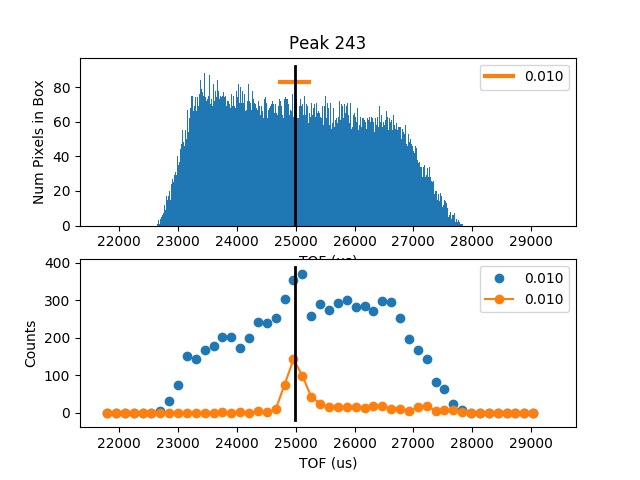

The top shows the number of pixels total in each time bin for constructing the TOF profile.  The bottom figure has the TOF profile constructed from all pixels (blue) and the BG-removed time of flight profile.  (Ignore the 0.01 for now - that's leftover from another idea I had.  Mostly I just use this to inspect individual peaks now.)  The black line show the TOF (from ```peak.getTOF()```).  

With that done you should be able to do a 3D fit by running some variant of this in the iPython terminal (note that this will redo the time of flight fit unless you feed it parameters.):

``` python
Y3D, goodIDX, pp_lambda, params = BVGFT.get3DPeak(peak, box, padeCoefficients,qMask,nTheta=50, nPhi=50, plotResults=True,nBG=5, dtBinWidth=dtBinWidth,zBG=1.96,fracBoxToHistogram=1.0,bgPolyOrder=1,numTimesToInterpolate=0, strongPeakParams=None, predCoefficients=predpplCoefficients, q_frame=q_frame, neigh_length_m=3,mindtBinWidth=mindtBinWidth)
```

Here's what those are:
- ```peak``` - the mantid peak object (loaded by getBox)
- ```box``` - the histogrammed events workspace (loaded by getBox)
- ```padeCoefficients``` - moderator coefficients - this will have to be something different outside the SNS probably.
- ```qMask``` - the mask for hkl-0.5 to hkl+0.5 (loaded by getBox)
- ```nTheta```, ```nPhi``` - the number of bins for histogramming the other two dimensions
- ```plotResults``` - boolean for if it should plot results.  If you're investigaing, you want that to be true.
- ```nBG``` - not useful anymore, but hasn't been removed yet
- ```dtBinWidth``` - not useful anymore, but hasn't been removed yet
- ```zBG``` - the Z value for assessing BG. 1.96 = 95% CI
- ```fracBoxToHistogram``` - allows you to only histogram (the 2D histogram) part of the box - usefully for very large boxes.  Number is the fraction of the box in each direction.
- ```bgPolyOrder``` - polynomial degree for TOF fitting.
- ```numTimesToInterpolate``` - Will put the final answer  (Y3D) onto a finer mesh with 2$^n$ more points.  0 is fine for testing and most peaks I've dealt with.
- ```strongPeakParams``` - strong peak profiles to force on weak peaks.  We'll deal with that later.
- ```predCoefficients``` - the predpplCoefficients from TOF fitting
- ```q_frame``` - either 'q_lab' or 'q_sample'
- ```neigh_length_m``` - box size for convolution (3 = nearest neighbor)
- ```mindtBinWidth``` - smallest dt for TOF fitting

and the outputs
- ```Y3D``` - an MxNxP numpy array containing the model intensities
- ```goodIDX``` - an MxNxP numpy array containing booleans for if they were included in the peak (True) or background (False)
- ```pp_lambda``` - the most likely number of background events
- ```params``` - a dictionary containing fit parameters

which should produce two images of this not-particularly-exemplary fit (though if you look at goodIDX you can see why the TOf profile doesn't go to zero where the fit does.)
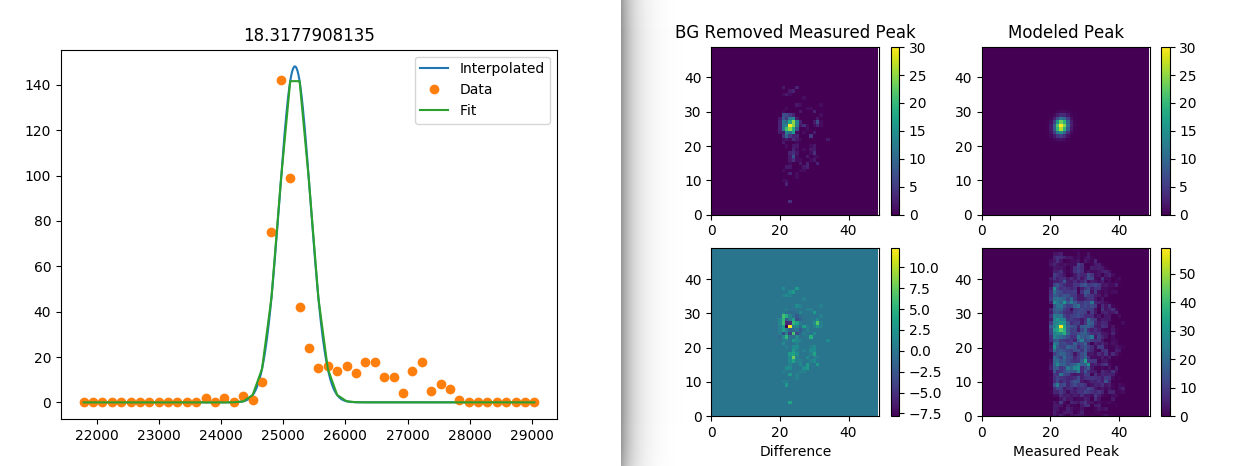


Now you have two numpy arrays for counts in reciprocal space - ```n_events``` is the actual histogrammed data and ```Y3D``` is the 3D model of the peak.  ```analysis/pySlice.py``` is a quick and dirty viewer I wrote to scroll through them side-by-side with your scroll wheel (though this program often requires you to close any matplotlib window - I need to go back and fix that).  You can run it with 
```python
pySlice.simpleSlices(n_events, Y3D)
```

